In [15]:
!pip install tensorflow-gpu

In [39]:
import os, sys, time, re, pickle, datetime as dt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf 
#import keras
from keras import regularizers
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D
#from keras.layers import Input, Dense, Dropout, Activation, Flatten, concatenate, Merge, Conv2D, MaxPooling2D
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

sns.set_palette('muted',color_codes=True)
vc_color = '#B5C9EB'

In [40]:
# DATA_DIR = "../data/raw/"
# TRAIN_DIR = DATA_DIR + "color_train/"
# VAL_DIR = DATA_DIR + "color_validation/"
# EXPORT_DIR = "../models/"
#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/My Drive/research_practice/plant_diseases/notebooks"

In [41]:
# For compatibility with folder structure on BR's computer
DATA_DIR = "../data/color/70_30/"
TRAIN_DIR = DATA_DIR + "/train/"
VAL_DIR = DATA_DIR + "/validation/"
EXPORT_DIR = "../models/"

In [42]:
IM_WIDTH, IM_HEIGHT = 64, 64
BATCH_SIZE = 16

In [43]:
# Get image classes
classes = os.listdir(TRAIN_DIR)
superclasses = list(set([x.split("_")[0] for x in classes]))
superclasses.sort()
num_classes = len(classes)
num_superclasses = len(superclasses)

# Get path and label for each image
db = []
for label, class_name in enumerate(classes):
    
    superclass_name = class_name.split("_")[0]
    
    # Train
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, superclass_name, 1])

    # Validation
    path = VAL_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, superclass_name, 0])

db = pd.DataFrame(db, columns=['file', 'label', 'class_name', 'superclass', 'train_ind'])

num_train_samples = db.train_ind.sum()
num_val_samples = len(db) - num_train_samples

In [44]:
db.head()

,file,label,class_name,superclass,train_ind
0,Apple___cedar_apple_rust/d523dfa0-a337-44db-a9...,0,Apple___cedar_apple_rust,Apple,1
1,Apple___cedar_apple_rust/4bd5f28f-beb3-4b27-b4...,0,Apple___cedar_apple_rust,Apple,1
2,Apple___cedar_apple_rust/91c6f875-414d-4449-93...,0,Apple___cedar_apple_rust,Apple,1
3,Apple___cedar_apple_rust/5b0cb1a1-e3ef-4503-88...,0,Apple___cedar_apple_rust,Apple,1
4,Apple___cedar_apple_rust/9f7d070e-f51d-4b14-86...,0,Apple___cedar_apple_rust,Apple,1


In [45]:
# Specify data generator inputs
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    rescale=1/255)

In [46]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE,
#     interpolation="bicubic"
)
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE,
#     interpolation="bicubic"
)

Found 38089 images belonging to 38 classes.
Found 16216 images belonging to 38 classes.


In [47]:
class_id2superclass_id = np.array([superclasses.index(x.split("_")[0]) for x in classes])

def wills_two_label_generator(existing_generator, class_id2superclass_id):
    for x_data, class_one_hots in existing_generator:
        #look up superclass ids
        superclass_ids = np.dot(class_one_hots,class_id2superclass_id)
        #one-hot-encode
        batch_size = superclass_ids.shape[0]
        superclass_one_hots = np.zeros((batch_size, num_superclasses))
        superclass_one_hots[np.arange(batch_size), superclass_ids.astype(int)] = 1

        yield(x_data, {'class_output': class_one_hots, 'superclass_output': superclass_one_hots} )

In [54]:
# Initiate optimizer
opt = tf.optimizers.Adam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, cooldown=5)

In [55]:
def plot_history(history, ax, categories, labels, yaxis_label = 'Accuracy'):
    for cat, lab in zip(categories, labels):
        ax.plot(history[cat], label=lab)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(yaxis_label)
    ax.legend(loc='best')

## Build Low-Parameter Superclass Model

In [56]:
main_input_super = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')

#shared origin 1
conv_leaf_0 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_super)
pooled_leaf_0 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_0)

#leaf block 1
conv_leaf_1 = Conv2D(16, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_leaf_0)
pooled_leaf_1 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_1)
dropped_leaf_1 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_1)

#disease block 1
conv_disease_1_2 = Conv2D(64, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_0)
pooled_disease_1 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_1_2)
dropped_disease_1 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_1)

#dense layer to predict leaf [plant type]
flat_leaf = Flatten()(dropped_leaf_1)
dense_leaf_1 = Dense(32, activation = 'relu')(flat_leaf) # Using less layers here as accuracy is less important
dense_leaf_drop = Dropout(0.3, name='leaf_dense_drop')(dense_leaf_1)
leaf_prediction = Dense(num_superclasses, activation = 'softmax', name='superclass_output')(dense_leaf_drop)

# dense layer to predict disease [plant type+disease type]
flat_disease_super = Flatten()(dropped_disease_1)
dense_disease_super = Dense(64, activation = 'relu')(flat_disease_super)

# combine networks and perform final categorization
combined_dense_disease = concatenate([dense_disease_super, leaf_prediction], axis=-1, name='final_combination')
dense_disease_drop = Dropout(0.3, name='final_drop')(combined_dense_disease)
disease_prediction = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_drop)
model_superclass = Model(inputs=[main_input_super], outputs=[disease_prediction, leaf_prediction])

In [66]:
# Compile model
model_superclass.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_superclass.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 shared_conv (Conv2D)           (None, 62, 62, 32)   896         ['image_input[0][0]']            
                                                                                                  
 shared_pool (MaxPooling2D)     (None, 31, 31, 32)   0           ['shared_conv[0][0]']            
                                                                                                  
 leaf_conv (Conv2D)             (None, 29, 29, 16)   4624        ['shared_pool[0][0]']            
                                                                                            

In [71]:
# Set up callbacks
model_name = "superclass_model"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [72]:
# Fit generator
results = model_superclass.fit(
    wills_two_label_generator(train_generator, class_id2superclass_id), epochs=40, steps_per_epoch=500, 
    validation_data=wills_two_label_generator(validation_generator, class_id2superclass_id), validation_steps=500,
    callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - 48s 96ms/step - loss: 2.8376 - class_output_loss: 1.5142 - superclass_output_loss: 1.3235 - class_output_accuracy: 0.5524 - superclass_output_accuracy: 0.5534 - val_loss: 2.5148 - val_class_output_loss: 1.3186 - val_superclass_output_loss: 1.1962 - val_class_output_accuracy: 0.6180 - val_superclass_output_accuracy: 0.6120 - lr: 0.0010
Epoch 2/40
500/500 [==============================] - 51s 101ms/step - loss: 2.8276 - class_output_loss: 1.4958 - superclass_output_loss: 1.3318 - class_output_accuracy: 0.5627 - superclass_output_accuracy: 0.5484 - val_loss: 2.3403 - val_class_output_loss: 1.2118 - val_superclass_output_loss: 1.1285 - val_class_output_accuracy: 0.6327 - val_superclass_output_accuracy: 0.6269 - lr: 0.0010
Epoch 3/40
500/500 [==============================] - 48s 96ms/step - loss: 2.7289 - class_output_loss: 1.4638 - superclass_output_loss: 1.2651 - class_output_accuracy: 0.5660 - superclass_output_accuracy: 0.5776 - va

500/500 [==============================] - 48s 96ms/step - loss: 2.3432 - class_output_loss: 1.1978 - superclass_output_loss: 1.1453 - class_output_accuracy: 0.6396 - superclass_output_accuracy: 0.6199 - val_loss: 1.7434 - val_class_output_loss: 0.8430 - val_superclass_output_loss: 0.9004 - val_class_output_accuracy: 0.7366 - val_superclass_output_accuracy: 0.6982 - lr: 0.0010
Epoch 14/40
500/500 [==============================] - 48s 96ms/step - loss: 2.2884 - class_output_loss: 1.1703 - superclass_output_loss: 1.1181 - class_output_accuracy: 0.6521 - superclass_output_accuracy: 0.6225 - val_loss: 1.7083 - val_class_output_loss: 0.8443 - val_superclass_output_loss: 0.8640 - val_class_output_accuracy: 0.7410 - val_superclass_output_accuracy: 0.7246 - lr: 0.0010
Epoch 15/40
500/500 [==============================] - 48s 95ms/step - loss: 2.2823 - class_output_loss: 1.1587 - superclass_output_loss: 1.1237 - class_output_accuracy: 0.6497 - superclass_output_accuracy: 0.6249 - val_loss: 1.

500/500 [==============================] - 60s 121ms/step - loss: 2.0634 - class_output_loss: 0.9966 - superclass_output_loss: 1.0668 - class_output_accuracy: 0.6926 - superclass_output_accuracy: 0.6439 - val_loss: 1.4112 - val_class_output_loss: 0.6503 - val_superclass_output_loss: 0.7609 - val_class_output_accuracy: 0.8048 - val_superclass_output_accuracy: 0.7539 - lr: 0.0010
Epoch 26/40
500/500 [==============================] - 62s 125ms/step - loss: 2.1269 - class_output_loss: 1.0386 - superclass_output_loss: 1.0883 - class_output_accuracy: 0.6799 - superclass_output_accuracy: 0.6366 - val_loss: 1.5170 - val_class_output_loss: 0.6592 - val_superclass_output_loss: 0.8578 - val_class_output_accuracy: 0.7997 - val_superclass_output_accuracy: 0.7130 - lr: 0.0010
Epoch 27/40
500/500 [==============================] - 61s 122ms/step - loss: 2.0226 - class_output_loss: 0.9842 - superclass_output_loss: 1.0384 - class_output_accuracy: 0.6952 - superclass_output_accuracy: 0.6556 - val_loss:

500/500 [==============================] - 49s 98ms/step - loss: 1.7074 - class_output_loss: 0.7750 - superclass_output_loss: 0.9324 - class_output_accuracy: 0.7583 - superclass_output_accuracy: 0.6833 - val_loss: 1.4374 - val_class_output_loss: 0.6542 - val_superclass_output_loss: 0.7832 - val_class_output_accuracy: 0.7956 - val_superclass_output_accuracy: 0.7471 - lr: 2.0000e-04
Epoch 38/40
500/500 [==============================] - 48s 96ms/step - loss: 1.7245 - class_output_loss: 0.7781 - superclass_output_loss: 0.9464 - class_output_accuracy: 0.7554 - superclass_output_accuracy: 0.6764 - val_loss: 1.4076 - val_class_output_loss: 0.6245 - val_superclass_output_loss: 0.7830 - val_class_output_accuracy: 0.8089 - val_superclass_output_accuracy: 0.7528 - lr: 2.0000e-04
Epoch 39/40
500/500 [==============================] - 48s 97ms/step - loss: 1.7200 - class_output_loss: 0.7847 - superclass_output_loss: 0.9352 - class_output_accuracy: 0.7569 - superclass_output_accuracy: 0.6856 - val_

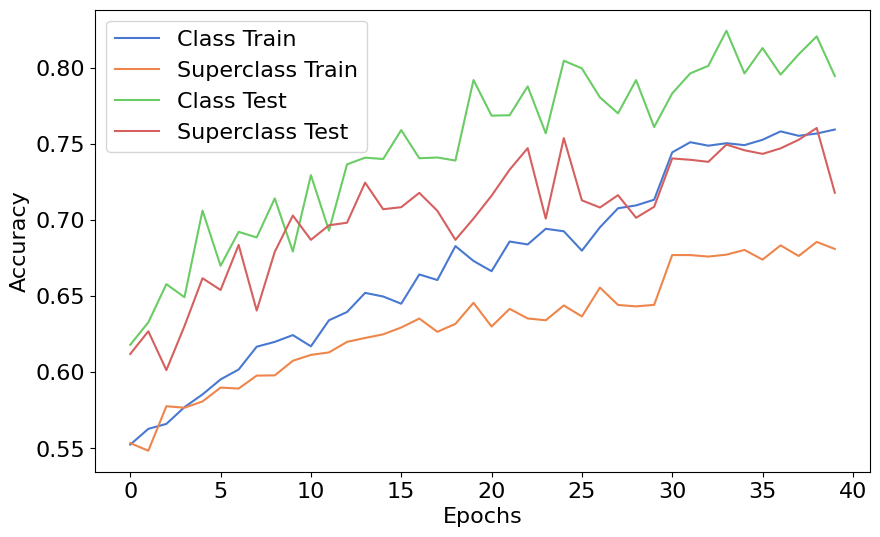

In [75]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['class_output_accuracy', 'superclass_output_accuracy', 'val_class_output_accuracy', 'val_superclass_output_accuracy'],
             ['Class Train', 'Superclass Train', 'Class Test', 'Superclass Test'])

In [95]:
with open('./train_history/superclass_lowparams.png', 'wb') as file_pi:
        pickle.dump(results.history, file_pi)

## Build Low-Parameter Baseline Model

In [77]:
# Already defined
main_input_base = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')
#shared origin 1
conv_leaf_base = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_base)
pooled_leaf_base = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_base)


# Not using
# #leaf block 1
# conv_leaf_1_2 = Conv2D(16, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_leaf_0)
# pooled_leaf_1 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_1_2)
# dropped_leaf_1 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_1)

#disease block 1
conv_disease_base = Conv2D(64, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_base)
pooled_disease_base = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_base)
dropped_disease_base = Dropout(0.10, name='disease_conv_drop')(pooled_disease_base)

# dense layer to predict disease [plant type+disease type]
flat_disease_base = Flatten()(dropped_disease_base)
dense_disease_base = Dense(64, activation = 'relu')(flat_disease_base)
dense_disease_base_drop = Dropout(0.3)(dense_disease_base)

disease_prediction_base = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_base_drop)
model_base = Model(inputs=[main_input_base], outputs=[disease_prediction_base])

In [78]:
model_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [79]:
model_base.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 shared_conv (Conv2D)        (None, 62, 62, 32)        896       
                                                                 
 shared_pool (MaxPooling2D)  (None, 31, 31, 32)        0         
                                                                 
 disease_conv (Conv2D)       (None, 29, 29, 64)        18496     
                                                                 
 disease_pool (MaxPooling2D)  (None, 14, 14, 64)       0         
                                                                 
 disease_conv_drop (Dropout)  (None, 14, 14, 64)       0         
                                                                 
 flatten_10 (Flatten)        (None, 12544)             0   

In [82]:
# Set up callbacks
model_name = "base_of_superclass_lowparams"
filepath = EXPORT_DIR + model_name + "{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [83]:
# Fit generator
results_base = model_base.fit_generator( train_generator, epochs=40, steps_per_epoch=500, 
    validation_data=validation_generator, validation_steps=500, callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 2.6353 - accuracy: 0.2957
Epoch 1: val_accuracy improved from -inf to 0.36713, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 42s 85ms/step - loss: 2.6353 - accuracy: 0.2957 - val_loss: 2.3582 - val_accuracy: 0.3671 - lr: 2.0000e-04
Epoch 2/40
500/500 [==============================] - ETA: 0s - loss: 2.4643 - accuracy: 0.3300
Epoch 2: val_accuracy improved from 0.36713 to 0.39913, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 2.4643 - accuracy: 0.3300 - val_loss: 2.1927 - val_accuracy: 0.3991 - lr: 2.0000e-04
Epoch 3/40
500/500 [==============================] - ETA: 0s - loss: 2.3180 - accuracy: 0.3620
Epoch 3: val_accuracy improved from 0.39913 to 0.41000, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 2.3180 - accuracy: 0.3620 - val_loss: 2.1638 - val_accuracy: 0.4100 - lr: 2.0000e-04
Epoch 4/40
500/500 [==============================] - ETA: 0s - loss: 2.1961 - accuracy: 0.3918
Epoch 4: val_accuracy improved from 0.41000 to 0.41137, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 2.1961 - accuracy: 0.3918 - val_loss: 2.1195 - val_accuracy: 0.4114 - lr: 2.0000e-04
Epoch 5/40
500/500 [==============================] - ETA: 0s - loss: 2.1022 - accuracy: 0.4144
Epoch 5: val_accuracy improved from 0.41137 to 0.48063, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 42s 85ms/step - loss: 2.1022 - accuracy: 0.4144 - val_loss: 1.8600 - val_accuracy: 0.4806 - lr: 2.0000e-04
Epoch 6/40
500/500 [==============================] - ETA: 0s - loss: 1.9987 - accuracy: 0.4369
Epoch 6: val_accuracy improved from 0.48063 to 0.48475, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 86ms/step - loss: 1.9987 - accuracy: 0.4369 - val_loss: 1.8172 - val_accuracy: 0.4848 - lr: 2.0000e-04
Epoch 7/40
500/500 [==============================] - ETA: 0s - loss: 1.9473 - accuracy: 0.4511
Epoch 7: val_accuracy did not improve from 0.48475
500/500 [==============================] - 42s 84ms/step - loss: 1.9473 - accuracy: 0.4511 - val_loss: 1.8547 - val_accuracy: 0.4812 - lr: 2.0000e-04
Epoch 8/40
500/500 [==============================] - ETA: 0s - loss: 1.8795 - accuracy: 0.4616
Epoch 8: val_accuracy did not improve from 0.48475
500/500 [==============================] - 42s 83ms/step - loss: 1.8795 - accuracy: 0.4616 - val_loss: 1.8724 - val_accuracy: 0.4770 - lr: 2.0000e-04
Epoch 9/40
500/500 [==============================] - ETA: 0s - loss: 1.8403 - accuracy: 0.4694
Epoch 9: val_accuracy improved from 0.48475 to 0.49788, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 1.8403 - accuracy: 0.4694 - val_loss: 1.7861 - val_accuracy: 0.4979 - lr: 2.0000e-04
Epoch 10/40
500/500 [==============================] - ETA: 0s - loss: 1.7667 - accuracy: 0.4814
Epoch 10: val_accuracy improved from 0.49788 to 0.51675, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 86ms/step - loss: 1.7667 - accuracy: 0.4814 - val_loss: 1.6361 - val_accuracy: 0.5167 - lr: 2.0000e-04
Epoch 11/40
500/500 [==============================] - ETA: 0s - loss: 1.7610 - accuracy: 0.4889
Epoch 11: val_accuracy improved from 0.51675 to 0.56775, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 1.7610 - accuracy: 0.4889 - val_loss: 1.4528 - val_accuracy: 0.5677 - lr: 2.0000e-04
Epoch 12/40
500/500 [==============================] - ETA: 0s - loss: 1.6954 - accuracy: 0.5029
Epoch 12: val_accuracy did not improve from 0.56775
500/500 [==============================] - 41s 83ms/step - loss: 1.6954 - accuracy: 0.5029 - val_loss: 1.5887 - val_accuracy: 0.5345 - lr: 2.0000e-04
Epoch 13/40
500/500 [==============================] - ETA: 0s - loss: 1.6606 - accuracy: 0.5102
Epoch 13: val_accuracy did not improve from 0.56775
500/500 [==============================] - 42s 83ms/step - loss: 1.6606 - accuracy: 0.5102 - val_loss: 1.5371 - val_accuracy: 0.5416 - lr: 2.0000e-04
Epoch 14/40
500/500 [==============================] - ETA: 0s - loss: 1.6198 - accuracy: 0.5272
Epoch 14: val_accuracy improved from 0.56775 to 0.58463, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 1.6198 - accuracy: 0.5272 - val_loss: 1.4046 - val_accuracy: 0.5846 - lr: 2.0000e-04
Epoch 15/40
500/500 [==============================] - ETA: 0s - loss: 1.5719 - accuracy: 0.5371
Epoch 15: val_accuracy did not improve from 0.58463
500/500 [==============================] - 41s 83ms/step - loss: 1.5719 - accuracy: 0.5371 - val_loss: 1.5231 - val_accuracy: 0.5535 - lr: 2.0000e-04
Epoch 16/40
500/500 [==============================] - ETA: 0s - loss: 1.6017 - accuracy: 0.5246
Epoch 16: val_accuracy improved from 0.58463 to 0.59137, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 86ms/step - loss: 1.6017 - accuracy: 0.5246 - val_loss: 1.3708 - val_accuracy: 0.5914 - lr: 2.0000e-04
Epoch 17/40
500/500 [==============================] - ETA: 0s - loss: 1.5514 - accuracy: 0.5424
Epoch 17: val_accuracy did not improve from 0.59137
500/500 [==============================] - 42s 84ms/step - loss: 1.5514 - accuracy: 0.5424 - val_loss: 1.4238 - val_accuracy: 0.5791 - lr: 2.0000e-04
Epoch 18/40
500/500 [==============================] - ETA: 0s - loss: 1.4971 - accuracy: 0.5540
Epoch 18: val_accuracy did not improve from 0.59137
500/500 [==============================] - 41s 82ms/step - loss: 1.4971 - accuracy: 0.5540 - val_loss: 1.6583 - val_accuracy: 0.5195 - lr: 2.0000e-04
Epoch 19/40
500/500 [==============================] - ETA: 0s - loss: 1.5494 - accuracy: 0.5454
Epoch 19: val_accuracy did not improve from 0.59137
500/500 [==============================] - 43s 85ms/step - loss: 1.5494 - accuracy: 0.5454 - val_loss: 

INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 86ms/step - loss: 1.5082 - accuracy: 0.5580 - val_loss: 1.2445 - val_accuracy: 0.6160 - lr: 2.0000e-04
Epoch 21/40
500/500 [==============================] - ETA: 0s - loss: 1.4958 - accuracy: 0.5575
Epoch 21: val_accuracy did not improve from 0.61600
500/500 [==============================] - 41s 82ms/step - loss: 1.4958 - accuracy: 0.5575 - val_loss: 1.3692 - val_accuracy: 0.5972 - lr: 2.0000e-04
Epoch 22/40
500/500 [==============================] - ETA: 0s - loss: 1.4634 - accuracy: 0.5636
Epoch 22: val_accuracy did not improve from 0.61600
500/500 [==============================] - 41s 83ms/step - loss: 1.4634 - accuracy: 0.5636 - val_loss: 1.3307 - val_accuracy: 0.5986 - lr: 2.0000e-04
Epoch 23/40
500/500 [==============================] - ETA: 0s - loss: 1.4579 - accuracy: 0.5706
Epoch 23: val_accuracy improved from 0.61600 to 0.62900, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 1.4579 - accuracy: 0.5706 - val_loss: 1.2147 - val_accuracy: 0.6290 - lr: 2.0000e-04
Epoch 24/40
500/500 [==============================] - ETA: 0s - loss: 1.4321 - accuracy: 0.5706
Epoch 24: val_accuracy did not improve from 0.62900
500/500 [==============================] - 42s 83ms/step - loss: 1.4321 - accuracy: 0.5706 - val_loss: 1.3228 - val_accuracy: 0.6014 - lr: 2.0000e-04
Epoch 25/40
500/500 [==============================] - ETA: 0s - loss: 1.4410 - accuracy: 0.5688
Epoch 25: val_accuracy did not improve from 0.62900
500/500 [==============================] - 41s 82ms/step - loss: 1.4410 - accuracy: 0.5688 - val_loss: 1.6098 - val_accuracy: 0.5479 - lr: 2.0000e-04
Epoch 26/40
500/500 [==============================] - ETA: 0s - loss: 1.3787 - accuracy: 0.5860
Epoch 26: val_accuracy did not improve from 0.62900
500/500 [==============================] - 41s 83ms/step - loss: 1.3787 - accuracy: 0.5860 - val_loss: 

INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 42s 85ms/step - loss: 1.3701 - accuracy: 0.5872 - val_loss: 1.1965 - val_accuracy: 0.6360 - lr: 2.0000e-04
Epoch 29/40
500/500 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.5846
Epoch 29: val_accuracy did not improve from 0.63600
500/500 [==============================] - 42s 83ms/step - loss: 1.3675 - accuracy: 0.5846 - val_loss: 1.2382 - val_accuracy: 0.6258 - lr: 2.0000e-04
Epoch 30/40
500/500 [==============================] - ETA: 0s - loss: 1.3552 - accuracy: 0.5913
Epoch 30: val_accuracy did not improve from 0.63600
500/500 [==============================] - 42s 83ms/step - loss: 1.3552 - accuracy: 0.5913 - val_loss: 1.3078 - val_accuracy: 0.6137 - lr: 2.0000e-04
Epoch 31/40
500/500 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.6015
Epoch 31: val_accuracy did not improve from 0.63600
500/500 [==============================] - 41s 83ms/step - loss: 1.3383 - accuracy: 0.6015 - val_loss: 

INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 44s 87ms/step - loss: 1.3198 - accuracy: 0.6065 - val_loss: 1.1793 - val_accuracy: 0.6420 - lr: 2.0000e-04
Epoch 34/40
500/500 [==============================] - ETA: 0s - loss: 1.3275 - accuracy: 0.5991
Epoch 34: val_accuracy did not improve from 0.64200
500/500 [==============================] - 42s 83ms/step - loss: 1.3275 - accuracy: 0.5991 - val_loss: 1.3964 - val_accuracy: 0.5905 - lr: 2.0000e-04
Epoch 35/40
500/500 [==============================] - ETA: 0s - loss: 1.2863 - accuracy: 0.6119
Epoch 35: val_accuracy did not improve from 0.64200
500/500 [==============================] - 41s 83ms/step - loss: 1.2863 - accuracy: 0.6119 - val_loss: 1.2820 - val_accuracy: 0.6220 - lr: 2.0000e-04
Epoch 36/40
500/500 [==============================] - ETA: 0s - loss: 1.3075 - accuracy: 0.6098
Epoch 36: val_accuracy improved from 0.64200 to 0.66500, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 86ms/step - loss: 1.3075 - accuracy: 0.6098 - val_loss: 1.0993 - val_accuracy: 0.6650 - lr: 2.0000e-04
Epoch 37/40
500/500 [==============================] - ETA: 0s - loss: 1.2542 - accuracy: 0.6162
Epoch 37: val_accuracy improved from 0.66500 to 0.67462, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 1.2542 - accuracy: 0.6162 - val_loss: 1.0568 - val_accuracy: 0.6746 - lr: 2.0000e-04
Epoch 38/40
500/500 [==============================] - ETA: 0s - loss: 1.2890 - accuracy: 0.6127
Epoch 38: val_accuracy did not improve from 0.67462
500/500 [==============================] - 41s 83ms/step - loss: 1.2890 - accuracy: 0.6127 - val_loss: 1.2373 - val_accuracy: 0.6357 - lr: 2.0000e-04
Epoch 39/40
500/500 [==============================] - ETA: 0s - loss: 1.2607 - accuracy: 0.6143
Epoch 39: val_accuracy did not improve from 0.67462
500/500 [==============================] - 41s 83ms/step - loss: 1.2607 - accuracy: 0.6143 - val_loss: 1.3307 - val_accuracy: 0.6223 - lr: 2.0000e-04
Epoch 40/40
500/500 [==============================] - ETA: 0s - loss: 1.2550 - accuracy: 0.6214
Epoch 40: val_accuracy improved from 0.67462 to 0.68725, saving model to ../models/base_of_superclass_lowparams.ckpt


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_lowparams.ckpt/assets


500/500 [==============================] - 43s 85ms/step - loss: 1.2550 - accuracy: 0.6214 - val_loss: 1.0327 - val_accuracy: 0.6873 - lr: 2.0000e-04


In [96]:
with open('./train_history/baseclass_lowparams.png', 'wb') as file_pi:
        pickle.dump(results_base.history, file_pi)

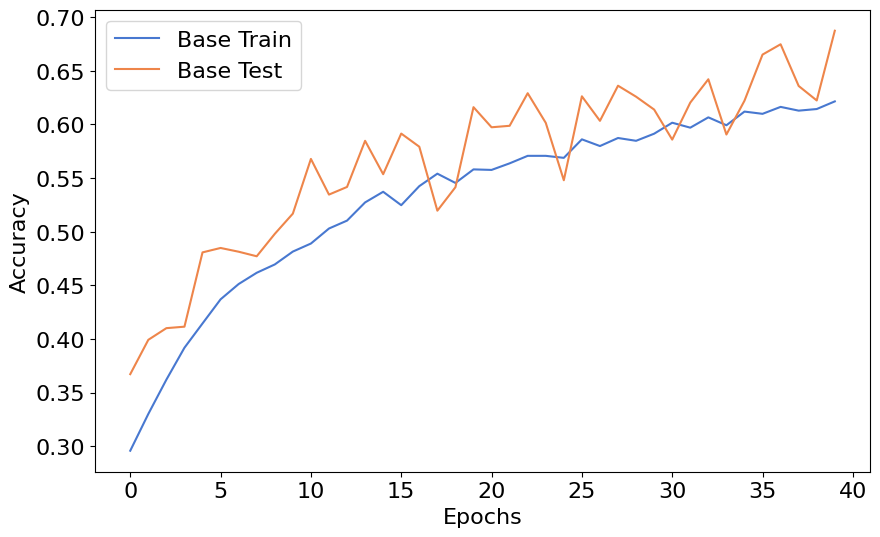

In [97]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_base.history, ax,
             ['accuracy', 'val_accuracy'],
             ['Base Train', 'Base Test'])

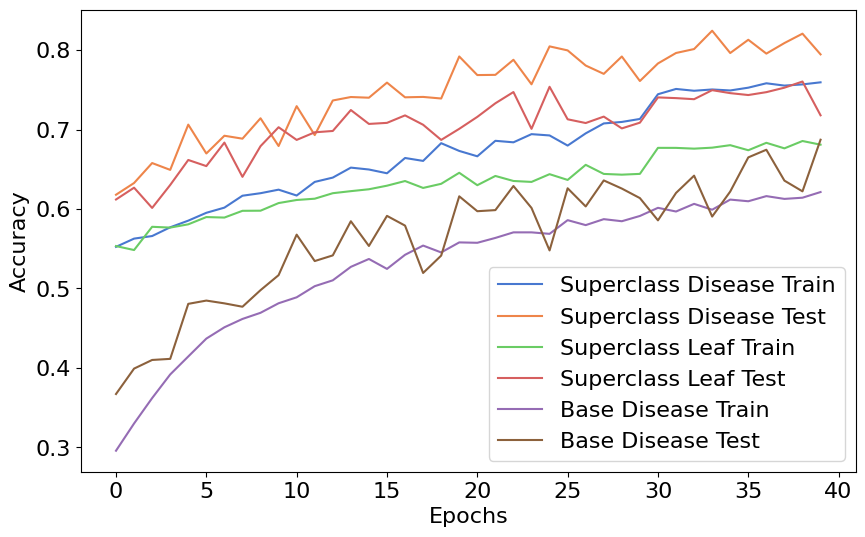

In [88]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['class_output_accuracy', 'val_class_output_accuracy', 'superclass_output_accuracy', 'val_superclass_output_accuracy'],
             ['Superclass Disease Train', 'Superclass Disease Test', 'Superclass Leaf Train', 'Superclass Leaf Test'])
plot_history(results_base.history, ax,
             ['accuracy', 'val_accuracy'],
             ['Base Disease Train', 'Base Disease Test'])

fig.savefig("./images/superclass_comparison_lowres_full.png")

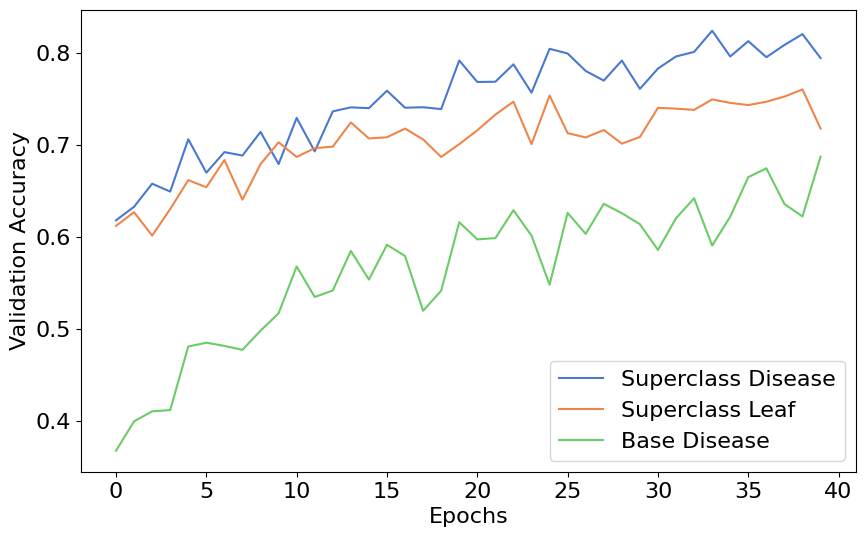

In [89]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['val_class_output_accuracy', 'val_superclass_output_accuracy'],
             ['Superclass Disease', 'Superclass Leaf'])
plot_history(results_base.history, ax,
             ['val_accuracy'],
             ['Base Disease'], yaxis_label="Validation Accuracy")

fig.savefig("./images/superclass_comparison_lowres.png")

## Build High-Parameter Baseline Model

In [90]:
# Already defined
main_input_base2 = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')
#shared origin 1
conv_leaf_base2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_base2)
pooled_leaf_base2 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_base2)

#disease block 1
conv_disease_base2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_base2)
pooled_disease_base2 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_base2)
dropped_disease_base2 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_base2)

# dense layer to predict disease [plant type+disease type]
flat_disease_base2 = Flatten()(dropped_disease_base2)
dense_disease_base2 = Dense(128, activation = 'relu')(flat_disease_base2)
dense_disease_base_drop2 = Dropout(0.3)(dense_disease_base2)

disease_prediction_base2 = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_base_drop2)
model_base2 = Model(inputs=[main_input_base2], outputs=[disease_prediction_base2])

In [91]:
model_base2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 shared_conv (Conv2D)        (None, 62, 62, 128)       3584      
                                                                 
 shared_pool (MaxPooling2D)  (None, 31, 31, 128)       0         
                                                                 
 disease_conv (Conv2D)       (None, 29, 29, 128)       147584    
                                                                 
 disease_pool (MaxPooling2D)  (None, 14, 14, 128)      0         
                                                                 
 disease_conv_drop (Dropout)  (None, 14, 14, 128)      0         
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0   

In [92]:
model_base2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [100]:
# Set up callbacks
model_name = "base_of_superclass_highparam_model"
os.makedirs(EXPORT_DIR + model_name)
filepath = EXPORT_DIR + model_name 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)
callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [101]:
# Fit generator
results_base2 = model_base2.fit_generator( train_generator, epochs=40, steps_per_epoch=500, 
    validation_data=validation_generator, validation_steps=500, callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 2.5929 - accuracy: 0.3031
Epoch 1: val_accuracy improved from -inf to 0.39562, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 136s 272ms/step - loss: 2.5929 - accuracy: 0.3031 - val_loss: 2.2372 - val_accuracy: 0.3956 - lr: 2.0000e-04
Epoch 2/40
500/500 [==============================] - ETA: 0s - loss: 2.2566 - accuracy: 0.3970
Epoch 2: val_accuracy improved from 0.39562 to 0.44012, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 136s 273ms/step - loss: 2.2566 - accuracy: 0.3970 - val_loss: 2.0570 - val_accuracy: 0.4401 - lr: 2.0000e-04
Epoch 3/40
500/500 [==============================] - ETA: 0s - loss: 2.0319 - accuracy: 0.4409
Epoch 3: val_accuracy improved from 0.44012 to 0.52175, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 135s 271ms/step - loss: 2.0319 - accuracy: 0.4409 - val_loss: 1.7074 - val_accuracy: 0.5217 - lr: 2.0000e-04
Epoch 4/40
500/500 [==============================] - ETA: 0s - loss: 1.8883 - accuracy: 0.4724
Epoch 4: val_accuracy did not improve from 0.52175
500/500 [==============================] - 135s 270ms/step - loss: 1.8883 - accuracy: 0.4724 - val_loss: 1.7801 - val_accuracy: 0.5025 - lr: 2.0000e-04
Epoch 5/40
500/500 [==============================] - ETA: 0s - loss: 1.7614 - accuracy: 0.4990
Epoch 5: val_accuracy did not improve from 0.52175
500/500 [==============================] - 133s 266ms/step - loss: 1.7614 - accuracy: 0.4990 - val_loss: 1.7095 - val_accuracy: 0.5190 - lr: 2.0000e-04
Epoch 6/40
500/500 [==============================] - ETA: 0s - loss: 1.6948 - accuracy: 0.5118
Epoch 6: val_accuracy improved from 0.52175 to 0.58288, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 134s 269ms/step - loss: 1.6948 - accuracy: 0.5118 - val_loss: 1.4591 - val_accuracy: 0.5829 - lr: 2.0000e-04
Epoch 7/40
500/500 [==============================] - ETA: 0s - loss: 1.6308 - accuracy: 0.5245
Epoch 7: val_accuracy did not improve from 0.58288
500/500 [==============================] - 136s 272ms/step - loss: 1.6308 - accuracy: 0.5245 - val_loss: 1.6428 - val_accuracy: 0.5186 - lr: 2.0000e-04
Epoch 8/40
500/500 [==============================] - ETA: 0s - loss: 1.5768 - accuracy: 0.5424
Epoch 8: val_accuracy improved from 0.58288 to 0.58575, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 138s 276ms/step - loss: 1.5768 - accuracy: 0.5424 - val_loss: 1.3889 - val_accuracy: 0.5857 - lr: 2.0000e-04
Epoch 9/40
500/500 [==============================] - ETA: 0s - loss: 1.5337 - accuracy: 0.5493
Epoch 9: val_accuracy improved from 0.58575 to 0.61975, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 138s 275ms/step - loss: 1.5337 - accuracy: 0.5493 - val_loss: 1.3041 - val_accuracy: 0.6198 - lr: 2.0000e-04
Epoch 10/40
500/500 [==============================] - ETA: 0s - loss: 1.4950 - accuracy: 0.5667
Epoch 10: val_accuracy did not improve from 0.61975
500/500 [==============================] - 135s 270ms/step - loss: 1.4950 - accuracy: 0.5667 - val_loss: 1.3638 - val_accuracy: 0.5899 - lr: 2.0000e-04
Epoch 11/40
500/500 [==============================] - ETA: 0s - loss: 1.4604 - accuracy: 0.5681
Epoch 11: val_accuracy improved from 0.61975 to 0.62362, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 134s 268ms/step - loss: 1.4604 - accuracy: 0.5681 - val_loss: 1.2683 - val_accuracy: 0.6236 - lr: 2.0000e-04
Epoch 12/40
500/500 [==============================] - ETA: 0s - loss: 1.4162 - accuracy: 0.5811
Epoch 12: val_accuracy did not improve from 0.62362
500/500 [==============================] - 133s 266ms/step - loss: 1.4162 - accuracy: 0.5811 - val_loss: 1.2899 - val_accuracy: 0.6230 - lr: 2.0000e-04
Epoch 13/40
500/500 [==============================] - ETA: 0s - loss: 1.3735 - accuracy: 0.5944
Epoch 13: val_accuracy improved from 0.62362 to 0.63063, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 139s 278ms/step - loss: 1.3735 - accuracy: 0.5944 - val_loss: 1.2598 - val_accuracy: 0.6306 - lr: 2.0000e-04
Epoch 14/40
500/500 [==============================] - ETA: 0s - loss: 1.3785 - accuracy: 0.5939
Epoch 14: val_accuracy improved from 0.63063 to 0.66438, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 136s 271ms/step - loss: 1.3785 - accuracy: 0.5939 - val_loss: 1.1445 - val_accuracy: 0.6644 - lr: 2.0000e-04
Epoch 15/40
500/500 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.5976
Epoch 15: val_accuracy did not improve from 0.66438
500/500 [==============================] - 146s 291ms/step - loss: 1.3300 - accuracy: 0.5976 - val_loss: 1.1886 - val_accuracy: 0.6467 - lr: 2.0000e-04
Epoch 16/40
500/500 [==============================] - ETA: 0s - loss: 1.3264 - accuracy: 0.6059
Epoch 16: val_accuracy did not improve from 0.66438
500/500 [==============================] - 135s 271ms/step - loss: 1.3264 - accuracy: 0.6059 - val_loss: 1.2485 - val_accuracy: 0.6292 - lr: 2.0000e-04
Epoch 17/40
500/500 [==============================] - ETA: 0s - loss: 1.2999 - accuracy: 0.6109
Epoch 17: val_accuracy did not improve from 0.66438
500/500 [==============================] - 135s 270ms/step - loss: 1.2999 - accuracy: 0.6109 - va

INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 135s 271ms/step - loss: 1.2280 - accuracy: 0.6285 - val_loss: 1.0493 - val_accuracy: 0.6839 - lr: 2.0000e-04
Epoch 21/40
500/500 [==============================] - ETA: 0s - loss: 1.1899 - accuracy: 0.6403
Epoch 21: val_accuracy did not improve from 0.68388
500/500 [==============================] - 134s 269ms/step - loss: 1.1899 - accuracy: 0.6403 - val_loss: 1.1229 - val_accuracy: 0.6711 - lr: 2.0000e-04
Epoch 22/40
500/500 [==============================] - ETA: 0s - loss: 1.2258 - accuracy: 0.6361
Epoch 22: val_accuracy did not improve from 0.68388
500/500 [==============================] - 164s 329ms/step - loss: 1.2258 - accuracy: 0.6361 - val_loss: 1.0329 - val_accuracy: 0.6805 - lr: 2.0000e-04
Epoch 23/40
500/500 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.6356
Epoch 23: val_accuracy did not improve from 0.68388
500/500 [==============================] - 172s 343ms/step - loss: 1.1981 - accuracy: 0.6356 - va

INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 171s 342ms/step - loss: 1.1488 - accuracy: 0.6482 - val_loss: 1.0339 - val_accuracy: 0.6867 - lr: 2.0000e-04
Epoch 26/40
500/500 [==============================] - ETA: 0s - loss: 1.1547 - accuracy: 0.6501
Epoch 26: val_accuracy improved from 0.68675 to 0.68825, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 169s 339ms/step - loss: 1.1547 - accuracy: 0.6501 - val_loss: 1.0510 - val_accuracy: 0.6883 - lr: 2.0000e-04
Epoch 27/40
500/500 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.6580
Epoch 27: val_accuracy did not improve from 0.68825
500/500 [==============================] - 170s 341ms/step - loss: 1.1148 - accuracy: 0.6580 - val_loss: 1.0498 - val_accuracy: 0.6883 - lr: 2.0000e-04
Epoch 28/40
500/500 [==============================] - ETA: 0s - loss: 1.0700 - accuracy: 0.6778
Epoch 28: val_accuracy improved from 0.68825 to 0.69275, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 174s 347ms/step - loss: 1.0700 - accuracy: 0.6778 - val_loss: 1.0049 - val_accuracy: 0.6927 - lr: 4.0000e-05
Epoch 29/40
500/500 [==============================] - ETA: 0s - loss: 1.0495 - accuracy: 0.6773
Epoch 29: val_accuracy improved from 0.69275 to 0.69650, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 174s 348ms/step - loss: 1.0495 - accuracy: 0.6773 - val_loss: 0.9990 - val_accuracy: 0.6965 - lr: 4.0000e-05
Epoch 30/40
500/500 [==============================] - ETA: 0s - loss: 1.0643 - accuracy: 0.6716
Epoch 30: val_accuracy improved from 0.69650 to 0.71763, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 173s 345ms/step - loss: 1.0643 - accuracy: 0.6716 - val_loss: 0.9118 - val_accuracy: 0.7176 - lr: 4.0000e-05
Epoch 31/40
500/500 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.6823
Epoch 31: val_accuracy did not improve from 0.71763
500/500 [==============================] - 170s 340ms/step - loss: 1.0280 - accuracy: 0.6823 - val_loss: 1.0431 - val_accuracy: 0.6902 - lr: 4.0000e-05
Epoch 32/40
500/500 [==============================] - ETA: 0s - loss: 1.0046 - accuracy: 0.6905
Epoch 32: val_accuracy did not improve from 0.71763
500/500 [==============================] - 169s 339ms/step - loss: 1.0046 - accuracy: 0.6905 - val_loss: 1.0041 - val_accuracy: 0.7006 - lr: 4.0000e-05
Epoch 33/40
500/500 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.6870
Epoch 33: val_accuracy did not improve from 0.71763
500/500 [==============================] - 171s 342ms/step - loss: 1.0270 - accuracy: 0.6870 - va

INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 173s 346ms/step - loss: 1.0395 - accuracy: 0.6746 - val_loss: 0.9218 - val_accuracy: 0.7179 - lr: 4.0000e-05
Epoch 35/40
500/500 [==============================] - ETA: 0s - loss: 1.0356 - accuracy: 0.6827
Epoch 35: val_accuracy improved from 0.71788 to 0.72088, saving model to ../models/base_of_superclass_highparam_model


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


INFO:tensorflow:Assets written to: ../models/base_of_superclass_highparam_model/assets


500/500 [==============================] - 148s 295ms/step - loss: 1.0356 - accuracy: 0.6827 - val_loss: 0.9158 - val_accuracy: 0.7209 - lr: 4.0000e-05
Epoch 36/40
500/500 [==============================] - ETA: 0s - loss: 0.9928 - accuracy: 0.6954
Epoch 36: val_accuracy did not improve from 0.72088
500/500 [==============================] - 160s 321ms/step - loss: 0.9928 - accuracy: 0.6954 - val_loss: 1.0108 - val_accuracy: 0.6949 - lr: 4.0000e-05
Epoch 37/40
500/500 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.6995
Epoch 37: val_accuracy did not improve from 0.72088
500/500 [==============================] - 205s 410ms/step - loss: 0.9766 - accuracy: 0.6995 - val_loss: 1.0330 - val_accuracy: 0.6906 - lr: 8.0000e-06
Epoch 38/40
500/500 [==============================] - ETA: 0s - loss: 1.0268 - accuracy: 0.6848
Epoch 38: val_accuracy did not improve from 0.72088
500/500 [==============================] - 205s 411ms/step - loss: 1.0268 - accuracy: 0.6848 - va

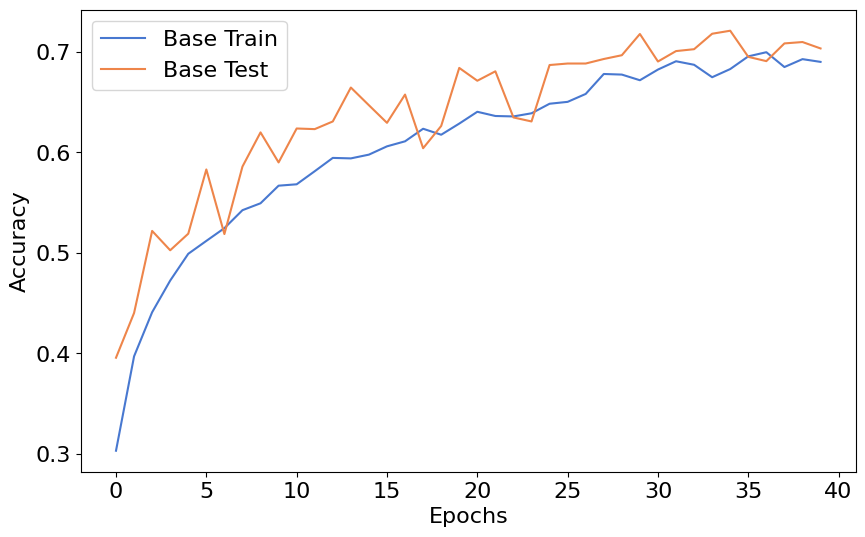

In [102]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_base2.history, ax,
             ['accuracy', 'val_accuracy'],
             ['Base Train', 'Base Test'])

In [104]:
with open('./train_history/baseclass_highparams.hist', 'wb') as file_pi:
        pickle.dump(results_base2.history, file_pi)

## Build High-Parameter Baseline Model

In [105]:
main_input_super2 = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')

#shared origin 1
conv_super2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_super2)
pooled_super2 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_super2)

#leaf block 1
conv_leaf_super2 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_super2)
pooled_leaf_super2 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_super2)
dropped_leaf_super2 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_super2)

#disease block 1
conv_disease_super2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_super2)
pooled_disease_super2 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_super2)
dropped_disease_super2 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_super2)

#dense layer to predict leaf [plant type]
flat_leaf_super2 = Flatten()(dropped_leaf_super2)
dense_leaf_super2 = Dense(64, activation = 'relu')(flat_leaf_super2) # Using less layers here as accuracy is less important
dense_leaf_drop_super2 = Dropout(0.3, name='leaf_dense_drop')(dense_leaf_super2)
leaf_prediction_super2 = Dense(num_superclasses, activation = 'softmax', name='superclass_output')(dense_leaf_drop_super2)

# dense layer to predict disease [plant type+disease type]
flat_disease_super2 = Flatten()(dropped_disease_super2)
dense_disease_super2 = Dense(128, activation = 'relu')(flat_disease_super2)

# combine networks and perform final categorization
combined_dense_disease_super2 = concatenate([dense_disease_super2, leaf_prediction_super2], axis=-1, name='final_combined')
dense_disease_drop_super2 = Dropout(0.3, name='final_drop')(combined_dense_disease_super2)

disease_prediction_super2 = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_drop_super2)
model_superclass_2 = Model(inputs=[main_input_super2], outputs=[disease_prediction_super2, leaf_prediction_super2])

In [106]:
model_superclass_2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 shared_conv (Conv2D)           (None, 62, 62, 128)  3584        ['image_input[0][0]']            
                                                                                                  
 shared_pool (MaxPooling2D)     (None, 31, 31, 128)  0           ['shared_conv[0][0]']            
                                                                                                  
 leaf_conv (Conv2D)             (None, 29, 29, 32)   36896       ['shared_pool[0][0]']            
                                                                                            

In [107]:
# Compile model
model_superclass_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [109]:
# Set up callbacks
model_name = "superclass_model_highparams"
os.makedirs(EXPORT_DIR + model_name)
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

FileExistsError: [Errno 17] File exists: '../models/superclass_model_highparams'

In [110]:
# Fit generator
results_superclass2 = model_superclass_2.fit_generator(
    wills_two_label_generator(train_generator, class_id2superclass_id),
    epochs=40,
    steps_per_epoch=500, 
    validation_data=wills_two_label_generator(validation_generator, class_id2superclass_id),
    validation_steps=500,
    callbacks=callbacks_list)

Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 5.7459 - class_output_loss: 3.3242 - superclass_output_loss: 2.4217 - class_output_accuracy: 0.1637 - superclass_output_accuracy: 0.2097WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 176s 350ms/step - loss: 5.7459 - class_output_loss: 3.3242 - superclass_output_loss: 2.4217 - class_output_accuracy: 0.1637 - superclass_output_accuracy: 0.2097 - val_loss: 5.3697 - val_class_output_loss: 3.0903 - val_superclass_output_loss: 2.2794 - val_class_output_accuracy: 0.2174 - val_superclass_output_accuracy: 0.2524 - lr: 8.0000e-06
Epoch 2/40
500/500 [==============================] - ETA: 0s - loss: 5.4055 - class_output_loss: 3.1064 - superclass_output_loss: 2.2991 - class_output_accuracy: 0.2103 - superclass_output_accuracy: 0.2634WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 171s 342ms/step - loss: 5.4055 - class_output_loss: 3.1064 - superclass_output_loss: 2.2991 - class_output_accuracy: 0.2103 - superclass_output_accuracy: 0.2634 - val_loss: 5.0609 - val_class_output_loss: 2.8976 - val_superclass_output_loss: 2.1633 - val_class_output_accuracy: 0.2639 - val_superclass_output_accuracy: 0.2897 - lr: 8.0000e-06
Epoch 3/40
500/500 [==============================] - ETA: 0s - loss: 5.2075 - class_output_loss: 2.9757 - superclass_output_loss: 2.2318 - class_output_accuracy: 0.2366 - superclass_output_accuracy: 0.2898WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 169s 339ms/step - loss: 5.2075 - class_output_loss: 2.9757 - superclass_output_loss: 2.2318 - class_output_accuracy: 0.2366 - superclass_output_accuracy: 0.2898 - val_loss: 4.8980 - val_class_output_loss: 2.8032 - val_superclass_output_loss: 2.0948 - val_class_output_accuracy: 0.2713 - val_superclass_output_accuracy: 0.3273 - lr: 8.0000e-06
Epoch 4/40
500/500 [==============================] - ETA: 0s - loss: 5.0839 - class_output_loss: 2.9024 - superclass_output_loss: 2.1815 - class_output_accuracy: 0.2567 - superclass_output_accuracy: 0.3047WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 170s 341ms/step - loss: 5.0839 - class_output_loss: 2.9024 - superclass_output_loss: 2.1815 - class_output_accuracy: 0.2567 - superclass_output_accuracy: 0.3047 - val_loss: 4.7586 - val_class_output_loss: 2.7133 - val_superclass_output_loss: 2.0453 - val_class_output_accuracy: 0.2877 - val_superclass_output_accuracy: 0.3466 - lr: 8.0000e-06
Epoch 5/40
500/500 [==============================] - ETA: 0s - loss: 4.9654 - class_output_loss: 2.8292 - superclass_output_loss: 2.1362 - class_output_accuracy: 0.2649 - superclass_output_accuracy: 0.3160WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 172s 345ms/step - loss: 4.9654 - class_output_loss: 2.8292 - superclass_output_loss: 2.1362 - class_output_accuracy: 0.2649 - superclass_output_accuracy: 0.3160 - val_loss: 4.6158 - val_class_output_loss: 2.6204 - val_superclass_output_loss: 1.9953 - val_class_output_accuracy: 0.3204 - val_superclass_output_accuracy: 0.3632 - lr: 8.0000e-06
Epoch 6/40
500/500 [==============================] - ETA: 0s - loss: 4.8842 - class_output_loss: 2.7650 - superclass_output_loss: 2.1192 - class_output_accuracy: 0.2801 - superclass_output_accuracy: 0.3248WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 174s 348ms/step - loss: 4.8842 - class_output_loss: 2.7650 - superclass_output_loss: 2.1192 - class_output_accuracy: 0.2801 - superclass_output_accuracy: 0.3248 - val_loss: 4.5347 - val_class_output_loss: 2.5654 - val_superclass_output_loss: 1.9692 - val_class_output_accuracy: 0.3475 - val_superclass_output_accuracy: 0.3791 - lr: 8.0000e-06
Epoch 7/40
500/500 [==============================] - ETA: 0s - loss: 4.7891 - class_output_loss: 2.6933 - superclass_output_loss: 2.0958 - class_output_accuracy: 0.2938 - superclass_output_accuracy: 0.3384WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 172s 345ms/step - loss: 4.7891 - class_output_loss: 2.6933 - superclass_output_loss: 2.0958 - class_output_accuracy: 0.2938 - superclass_output_accuracy: 0.3384 - val_loss: 4.4415 - val_class_output_loss: 2.4839 - val_superclass_output_loss: 1.9576 - val_class_output_accuracy: 0.3501 - val_superclass_output_accuracy: 0.3817 - lr: 8.0000e-06
Epoch 8/40
500/500 [==============================] - ETA: 0s - loss: 4.7367 - class_output_loss: 2.6583 - superclass_output_loss: 2.0783 - class_output_accuracy: 0.3029 - superclass_output_accuracy: 0.3445WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 171s 343ms/step - loss: 4.7367 - class_output_loss: 2.6583 - superclass_output_loss: 2.0783 - class_output_accuracy: 0.3029 - superclass_output_accuracy: 0.3445 - val_loss: 4.4244 - val_class_output_loss: 2.4780 - val_superclass_output_loss: 1.9464 - val_class_output_accuracy: 0.3595 - val_superclass_output_accuracy: 0.3930 - lr: 8.0000e-06
Epoch 9/40
500/500 [==============================] - ETA: 0s - loss: 4.6668 - class_output_loss: 2.6086 - superclass_output_loss: 2.0582 - class_output_accuracy: 0.3180 - superclass_output_accuracy: 0.3553WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 172s 344ms/step - loss: 4.6668 - class_output_loss: 2.6086 - superclass_output_loss: 2.0582 - class_output_accuracy: 0.3180 - superclass_output_accuracy: 0.3553 - val_loss: 4.3355 - val_class_output_loss: 2.4027 - val_superclass_output_loss: 1.9328 - val_class_output_accuracy: 0.3611 - val_superclass_output_accuracy: 0.4056 - lr: 8.0000e-06
Epoch 10/40
500/500 [==============================] - ETA: 0s - loss: 4.6405 - class_output_loss: 2.5981 - superclass_output_loss: 2.0424 - class_output_accuracy: 0.3155 - superclass_output_accuracy: 0.3559WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 173s 345ms/step - loss: 4.6405 - class_output_loss: 2.5981 - superclass_output_loss: 2.0424 - class_output_accuracy: 0.3155 - superclass_output_accuracy: 0.3559 - val_loss: 4.3258 - val_class_output_loss: 2.3959 - val_superclass_output_loss: 1.9299 - val_class_output_accuracy: 0.3741 - val_superclass_output_accuracy: 0.3946 - lr: 8.0000e-06
Epoch 11/40
500/500 [==============================] - ETA: 0s - loss: 4.5856 - class_output_loss: 2.5599 - superclass_output_loss: 2.0257 - class_output_accuracy: 0.3229 - superclass_output_accuracy: 0.3618WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 173s 346ms/step - loss: 4.5856 - class_output_loss: 2.5599 - superclass_output_loss: 2.0257 - class_output_accuracy: 0.3229 - superclass_output_accuracy: 0.3618 - val_loss: 4.2282 - val_class_output_loss: 2.3407 - val_superclass_output_loss: 1.8875 - val_class_output_accuracy: 0.3961 - val_superclass_output_accuracy: 0.4196 - lr: 8.0000e-06
Epoch 12/40
500/500 [==============================] - ETA: 0s - loss: 4.5283 - class_output_loss: 2.5105 - superclass_output_loss: 2.0177 - class_output_accuracy: 0.3340 - superclass_output_accuracy: 0.3641WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 173s 345ms/step - loss: 4.5283 - class_output_loss: 2.5105 - superclass_output_loss: 2.0177 - class_output_accuracy: 0.3340 - superclass_output_accuracy: 0.3641 - val_loss: 4.1832 - val_class_output_loss: 2.2895 - val_superclass_output_loss: 1.8937 - val_class_output_accuracy: 0.3973 - val_superclass_output_accuracy: 0.4137 - lr: 8.0000e-06
Epoch 13/40
500/500 [==============================] - ETA: 0s - loss: 4.5029 - class_output_loss: 2.4893 - superclass_output_loss: 2.0136 - class_output_accuracy: 0.3431 - superclass_output_accuracy: 0.3634WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 172s 345ms/step - loss: 4.5029 - class_output_loss: 2.4893 - superclass_output_loss: 2.0136 - class_output_accuracy: 0.3431 - superclass_output_accuracy: 0.3634 - val_loss: 4.1336 - val_class_output_loss: 2.2616 - val_superclass_output_loss: 1.8720 - val_class_output_accuracy: 0.3994 - val_superclass_output_accuracy: 0.4232 - lr: 8.0000e-06
Epoch 14/40
500/500 [==============================] - ETA: 0s - loss: 4.4678 - class_output_loss: 2.4661 - superclass_output_loss: 2.0016 - class_output_accuracy: 0.3459 - superclass_output_accuracy: 0.3722WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 169s 339ms/step - loss: 4.4678 - class_output_loss: 2.4661 - superclass_output_loss: 2.0016 - class_output_accuracy: 0.3459 - superclass_output_accuracy: 0.3722 - val_loss: 4.1324 - val_class_output_loss: 2.2677 - val_superclass_output_loss: 1.8647 - val_class_output_accuracy: 0.4192 - val_superclass_output_accuracy: 0.4257 - lr: 8.0000e-06
Epoch 15/40
500/500 [==============================] - ETA: 0s - loss: 4.3641 - class_output_loss: 2.4086 - superclass_output_loss: 1.9555 - class_output_accuracy: 0.3549 - superclass_output_accuracy: 0.3805WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 170s 340ms/step - loss: 4.3641 - class_output_loss: 2.4086 - superclass_output_loss: 1.9555 - class_output_accuracy: 0.3549 - superclass_output_accuracy: 0.3805 - val_loss: 4.0559 - val_class_output_loss: 2.2098 - val_superclass_output_loss: 1.8462 - val_class_output_accuracy: 0.4123 - val_superclass_output_accuracy: 0.4260 - lr: 8.0000e-06
Epoch 16/40
500/500 [==============================] - ETA: 0s - loss: 4.3981 - class_output_loss: 2.4187 - superclass_output_loss: 1.9794 - class_output_accuracy: 0.3498 - superclass_output_accuracy: 0.3806WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 176s 352ms/step - loss: 4.3981 - class_output_loss: 2.4187 - superclass_output_loss: 1.9794 - class_output_accuracy: 0.3498 - superclass_output_accuracy: 0.3806 - val_loss: 4.1049 - val_class_output_loss: 2.2586 - val_superclass_output_loss: 1.8463 - val_class_output_accuracy: 0.4093 - val_superclass_output_accuracy: 0.4257 - lr: 8.0000e-06
Epoch 17/40
500/500 [==============================] - ETA: 0s - loss: 4.3561 - class_output_loss: 2.3902 - superclass_output_loss: 1.9659 - class_output_accuracy: 0.3606 - superclass_output_accuracy: 0.3728WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 175s 351ms/step - loss: 4.3561 - class_output_loss: 2.3902 - superclass_output_loss: 1.9659 - class_output_accuracy: 0.3606 - superclass_output_accuracy: 0.3728 - val_loss: 4.0037 - val_class_output_loss: 2.1822 - val_superclass_output_loss: 1.8215 - val_class_output_accuracy: 0.4219 - val_superclass_output_accuracy: 0.4395 - lr: 8.0000e-06
Epoch 18/40
500/500 [==============================] - ETA: 0s - loss: 4.3068 - class_output_loss: 2.3618 - superclass_output_loss: 1.9450 - class_output_accuracy: 0.3644 - superclass_output_accuracy: 0.3968WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 221s 443ms/step - loss: 4.3068 - class_output_loss: 2.3618 - superclass_output_loss: 1.9450 - class_output_accuracy: 0.3644 - superclass_output_accuracy: 0.3968 - val_loss: 3.9909 - val_class_output_loss: 2.1834 - val_superclass_output_loss: 1.8075 - val_class_output_accuracy: 0.4291 - val_superclass_output_accuracy: 0.4397 - lr: 8.0000e-06
Epoch 19/40
500/500 [==============================] - ETA: 0s - loss: 4.2485 - class_output_loss: 2.3158 - superclass_output_loss: 1.9327 - class_output_accuracy: 0.3758 - superclass_output_accuracy: 0.3882WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 259s 518ms/step - loss: 4.2485 - class_output_loss: 2.3158 - superclass_output_loss: 1.9327 - class_output_accuracy: 0.3758 - superclass_output_accuracy: 0.3882 - val_loss: 4.0279 - val_class_output_loss: 2.1910 - val_superclass_output_loss: 1.8368 - val_class_output_accuracy: 0.4199 - val_superclass_output_accuracy: 0.4336 - lr: 8.0000e-06
Epoch 20/40
500/500 [==============================] - ETA: 0s - loss: 4.3025 - class_output_loss: 2.3467 - superclass_output_loss: 1.9558 - class_output_accuracy: 0.3715 - superclass_output_accuracy: 0.3786WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 259s 518ms/step - loss: 4.3025 - class_output_loss: 2.3467 - superclass_output_loss: 1.9558 - class_output_accuracy: 0.3715 - superclass_output_accuracy: 0.3786 - val_loss: 3.9093 - val_class_output_loss: 2.1142 - val_superclass_output_loss: 1.7951 - val_class_output_accuracy: 0.4432 - val_superclass_output_accuracy: 0.4458 - lr: 8.0000e-06
Epoch 21/40
500/500 [==============================] - ETA: 0s - loss: 4.2629 - class_output_loss: 2.3269 - superclass_output_loss: 1.9359 - class_output_accuracy: 0.3746 - superclass_output_accuracy: 0.3890WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 226s 451ms/step - loss: 4.2629 - class_output_loss: 2.3269 - superclass_output_loss: 1.9359 - class_output_accuracy: 0.3746 - superclass_output_accuracy: 0.3890 - val_loss: 3.9274 - val_class_output_loss: 2.1187 - val_superclass_output_loss: 1.8087 - val_class_output_accuracy: 0.4340 - val_superclass_output_accuracy: 0.4403 - lr: 8.0000e-06
Epoch 22/40
500/500 [==============================] - ETA: 0s - loss: 4.1988 - class_output_loss: 2.2863 - superclass_output_loss: 1.9126 - class_output_accuracy: 0.3873 - superclass_output_accuracy: 0.3979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 255s 510ms/step - loss: 4.1988 - class_output_loss: 2.2863 - superclass_output_loss: 1.9126 - class_output_accuracy: 0.3873 - superclass_output_accuracy: 0.3979 - val_loss: 3.8802 - val_class_output_loss: 2.0848 - val_superclass_output_loss: 1.7954 - val_class_output_accuracy: 0.4329 - val_superclass_output_accuracy: 0.4433 - lr: 8.0000e-06
Epoch 23/40
500/500 [==============================] - ETA: 0s - loss: 4.1763 - class_output_loss: 2.2628 - superclass_output_loss: 1.9136 - class_output_accuracy: 0.3898 - superclass_output_accuracy: 0.3927WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 258s 516ms/step - loss: 4.1763 - class_output_loss: 2.2628 - superclass_output_loss: 1.9136 - class_output_accuracy: 0.3898 - superclass_output_accuracy: 0.3927 - val_loss: 3.9029 - val_class_output_loss: 2.1125 - val_superclass_output_loss: 1.7905 - val_class_output_accuracy: 0.4439 - val_superclass_output_accuracy: 0.4464 - lr: 8.0000e-06
Epoch 24/40
500/500 [==============================] - ETA: 0s - loss: 4.1462 - class_output_loss: 2.2447 - superclass_output_loss: 1.9015 - class_output_accuracy: 0.3909 - superclass_output_accuracy: 0.3970WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 233s 466ms/step - loss: 4.1462 - class_output_loss: 2.2447 - superclass_output_loss: 1.9015 - class_output_accuracy: 0.3909 - superclass_output_accuracy: 0.3970 - val_loss: 3.8382 - val_class_output_loss: 2.0714 - val_superclass_output_loss: 1.7668 - val_class_output_accuracy: 0.4412 - val_superclass_output_accuracy: 0.4487 - lr: 8.0000e-06
Epoch 25/40
500/500 [==============================] - ETA: 0s - loss: 4.0736 - class_output_loss: 2.1921 - superclass_output_loss: 1.8815 - class_output_accuracy: 0.4079 - superclass_output_accuracy: 0.4094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 255s 511ms/step - loss: 4.0736 - class_output_loss: 2.1921 - superclass_output_loss: 1.8815 - class_output_accuracy: 0.4079 - superclass_output_accuracy: 0.4094 - val_loss: 3.8179 - val_class_output_loss: 2.0507 - val_superclass_output_loss: 1.7673 - val_class_output_accuracy: 0.4535 - val_superclass_output_accuracy: 0.4450 - lr: 8.0000e-06
Epoch 26/40
500/500 [==============================] - ETA: 0s - loss: 4.0776 - class_output_loss: 2.2057 - superclass_output_loss: 1.8720 - class_output_accuracy: 0.4029 - superclass_output_accuracy: 0.4096WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 258s 517ms/step - loss: 4.0776 - class_output_loss: 2.2057 - superclass_output_loss: 1.8720 - class_output_accuracy: 0.4029 - superclass_output_accuracy: 0.4096 - val_loss: 3.7904 - val_class_output_loss: 2.0425 - val_superclass_output_loss: 1.7479 - val_class_output_accuracy: 0.4417 - val_superclass_output_accuracy: 0.4512 - lr: 8.0000e-06
Epoch 27/40
500/500 [==============================] - ETA: 0s - loss: 4.0682 - class_output_loss: 2.2005 - superclass_output_loss: 1.8677 - class_output_accuracy: 0.4019 - superclass_output_accuracy: 0.4070WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 246s 493ms/step - loss: 4.0682 - class_output_loss: 2.2005 - superclass_output_loss: 1.8677 - class_output_accuracy: 0.4019 - superclass_output_accuracy: 0.4070 - val_loss: 3.7817 - val_class_output_loss: 2.0186 - val_superclass_output_loss: 1.7631 - val_class_output_accuracy: 0.4618 - val_superclass_output_accuracy: 0.4495 - lr: 8.0000e-06
Epoch 28/40
500/500 [==============================] - ETA: 0s - loss: 4.0202 - class_output_loss: 2.1660 - superclass_output_loss: 1.8541 - class_output_accuracy: 0.4146 - superclass_output_accuracy: 0.4173WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 238s 476ms/step - loss: 4.0202 - class_output_loss: 2.1660 - superclass_output_loss: 1.8541 - class_output_accuracy: 0.4146 - superclass_output_accuracy: 0.4173 - val_loss: 3.7284 - val_class_output_loss: 2.0128 - val_superclass_output_loss: 1.7156 - val_class_output_accuracy: 0.4494 - val_superclass_output_accuracy: 0.4556 - lr: 8.0000e-06
Epoch 29/40
500/500 [==============================] - ETA: 0s - loss: 4.0044 - class_output_loss: 2.1545 - superclass_output_loss: 1.8499 - class_output_accuracy: 0.4131 - superclass_output_accuracy: 0.4202WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 260s 520ms/step - loss: 4.0044 - class_output_loss: 2.1545 - superclass_output_loss: 1.8499 - class_output_accuracy: 0.4131 - superclass_output_accuracy: 0.4202 - val_loss: 3.7407 - val_class_output_loss: 2.0143 - val_superclass_output_loss: 1.7264 - val_class_output_accuracy: 0.4559 - val_superclass_output_accuracy: 0.4549 - lr: 8.0000e-06
Epoch 30/40
500/500 [==============================] - ETA: 0s - loss: 3.9974 - class_output_loss: 2.1334 - superclass_output_loss: 1.8639 - class_output_accuracy: 0.4171 - superclass_output_accuracy: 0.4091WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 256s 513ms/step - loss: 3.9974 - class_output_loss: 2.1334 - superclass_output_loss: 1.8639 - class_output_accuracy: 0.4171 - superclass_output_accuracy: 0.4091 - val_loss: 3.7530 - val_class_output_loss: 2.0139 - val_superclass_output_loss: 1.7391 - val_class_output_accuracy: 0.4546 - val_superclass_output_accuracy: 0.4510 - lr: 8.0000e-06
Epoch 31/40
500/500 [==============================] - ETA: 0s - loss: 3.9586 - class_output_loss: 2.1101 - superclass_output_loss: 1.8484 - class_output_accuracy: 0.4247 - superclass_output_accuracy: 0.4125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 221s 442ms/step - loss: 3.9586 - class_output_loss: 2.1101 - superclass_output_loss: 1.8484 - class_output_accuracy: 0.4247 - superclass_output_accuracy: 0.4125 - val_loss: 3.6988 - val_class_output_loss: 1.9825 - val_superclass_output_loss: 1.7164 - val_class_output_accuracy: 0.4577 - val_superclass_output_accuracy: 0.4510 - lr: 8.0000e-06
Epoch 32/40
500/500 [==============================] - ETA: 0s - loss: 3.9041 - class_output_loss: 2.0829 - superclass_output_loss: 1.8211 - class_output_accuracy: 0.4288 - superclass_output_accuracy: 0.4212WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 256s 512ms/step - loss: 3.9041 - class_output_loss: 2.0829 - superclass_output_loss: 1.8211 - class_output_accuracy: 0.4288 - superclass_output_accuracy: 0.4212 - val_loss: 3.6490 - val_class_output_loss: 1.9546 - val_superclass_output_loss: 1.6944 - val_class_output_accuracy: 0.4693 - val_superclass_output_accuracy: 0.4611 - lr: 8.0000e-06
Epoch 33/40
500/500 [==============================] - ETA: 0s - loss: 3.8910 - class_output_loss: 2.0658 - superclass_output_loss: 1.8252 - class_output_accuracy: 0.4391 - superclass_output_accuracy: 0.4129WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 258s 516ms/step - loss: 3.8910 - class_output_loss: 2.0658 - superclass_output_loss: 1.8252 - class_output_accuracy: 0.4391 - superclass_output_accuracy: 0.4129 - val_loss: 3.6393 - val_class_output_loss: 1.9435 - val_superclass_output_loss: 1.6958 - val_class_output_accuracy: 0.4680 - val_superclass_output_accuracy: 0.4620 - lr: 8.0000e-06
Epoch 34/40
500/500 [==============================] - ETA: 0s - loss: 3.9222 - class_output_loss: 2.1043 - superclass_output_loss: 1.8179 - class_output_accuracy: 0.4241 - superclass_output_accuracy: 0.4231WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 228s 456ms/step - loss: 3.9222 - class_output_loss: 2.1043 - superclass_output_loss: 1.8179 - class_output_accuracy: 0.4241 - superclass_output_accuracy: 0.4231 - val_loss: 3.6371 - val_class_output_loss: 1.9343 - val_superclass_output_loss: 1.7027 - val_class_output_accuracy: 0.4662 - val_superclass_output_accuracy: 0.4527 - lr: 8.0000e-06
Epoch 35/40
500/500 [==============================] - ETA: 0s - loss: 3.8929 - class_output_loss: 2.0793 - superclass_output_loss: 1.8136 - class_output_accuracy: 0.4355 - superclass_output_accuracy: 0.4130WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 252s 505ms/step - loss: 3.8929 - class_output_loss: 2.0793 - superclass_output_loss: 1.8136 - class_output_accuracy: 0.4355 - superclass_output_accuracy: 0.4130 - val_loss: 3.6102 - val_class_output_loss: 1.9349 - val_superclass_output_loss: 1.6753 - val_class_output_accuracy: 0.4606 - val_superclass_output_accuracy: 0.4548 - lr: 8.0000e-06
Epoch 36/40
500/500 [==============================] - ETA: 0s - loss: 3.8402 - class_output_loss: 2.0264 - superclass_output_loss: 1.8138 - class_output_accuracy: 0.4430 - superclass_output_accuracy: 0.4271WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 258s 517ms/step - loss: 3.8402 - class_output_loss: 2.0264 - superclass_output_loss: 1.8138 - class_output_accuracy: 0.4430 - superclass_output_accuracy: 0.4271 - val_loss: 3.6043 - val_class_output_loss: 1.9337 - val_superclass_output_loss: 1.6706 - val_class_output_accuracy: 0.4696 - val_superclass_output_accuracy: 0.4648 - lr: 8.0000e-06
Epoch 37/40
500/500 [==============================] - ETA: 0s - loss: 3.8328 - class_output_loss: 2.0273 - superclass_output_loss: 1.8056 - class_output_accuracy: 0.4476 - superclass_output_accuracy: 0.4284WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 246s 492ms/step - loss: 3.8328 - class_output_loss: 2.0273 - superclass_output_loss: 1.8056 - class_output_accuracy: 0.4476 - superclass_output_accuracy: 0.4284 - val_loss: 3.5426 - val_class_output_loss: 1.8887 - val_superclass_output_loss: 1.6539 - val_class_output_accuracy: 0.4748 - val_superclass_output_accuracy: 0.4611 - lr: 8.0000e-06
Epoch 38/40
500/500 [==============================] - ETA: 0s - loss: 3.8554 - class_output_loss: 2.0681 - superclass_output_loss: 1.7873 - class_output_accuracy: 0.4374 - superclass_output_accuracy: 0.4372WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 241s 482ms/step - loss: 3.8554 - class_output_loss: 2.0681 - superclass_output_loss: 1.7873 - class_output_accuracy: 0.4374 - superclass_output_accuracy: 0.4372 - val_loss: 3.5983 - val_class_output_loss: 1.9363 - val_superclass_output_loss: 1.6620 - val_class_output_accuracy: 0.4705 - val_superclass_output_accuracy: 0.4655 - lr: 8.0000e-06
Epoch 39/40
500/500 [==============================] - ETA: 0s - loss: 3.7902 - class_output_loss: 2.0202 - superclass_output_loss: 1.7700 - class_output_accuracy: 0.4502 - superclass_output_accuracy: 0.4327WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 257s 515ms/step - loss: 3.7902 - class_output_loss: 2.0202 - superclass_output_loss: 1.7700 - class_output_accuracy: 0.4502 - superclass_output_accuracy: 0.4327 - val_loss: 3.6054 - val_class_output_loss: 1.9321 - val_superclass_output_loss: 1.6734 - val_class_output_accuracy: 0.4626 - val_superclass_output_accuracy: 0.4582 - lr: 8.0000e-06
Epoch 40/40
500/500 [==============================] - ETA: 0s - loss: 3.8044 - class_output_loss: 2.0069 - superclass_output_loss: 1.7975 - class_output_accuracy: 0.4496 - superclass_output_accuracy: 0.4285WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


500/500 [==============================] - 256s 513ms/step - loss: 3.8044 - class_output_loss: 2.0069 - superclass_output_loss: 1.7975 - class_output_accuracy: 0.4496 - superclass_output_accuracy: 0.4285 - val_loss: 3.5010 - val_class_output_loss: 1.8789 - val_superclass_output_loss: 1.6221 - val_class_output_accuracy: 0.4789 - val_superclass_output_accuracy: 0.4738 - lr: 8.0000e-06


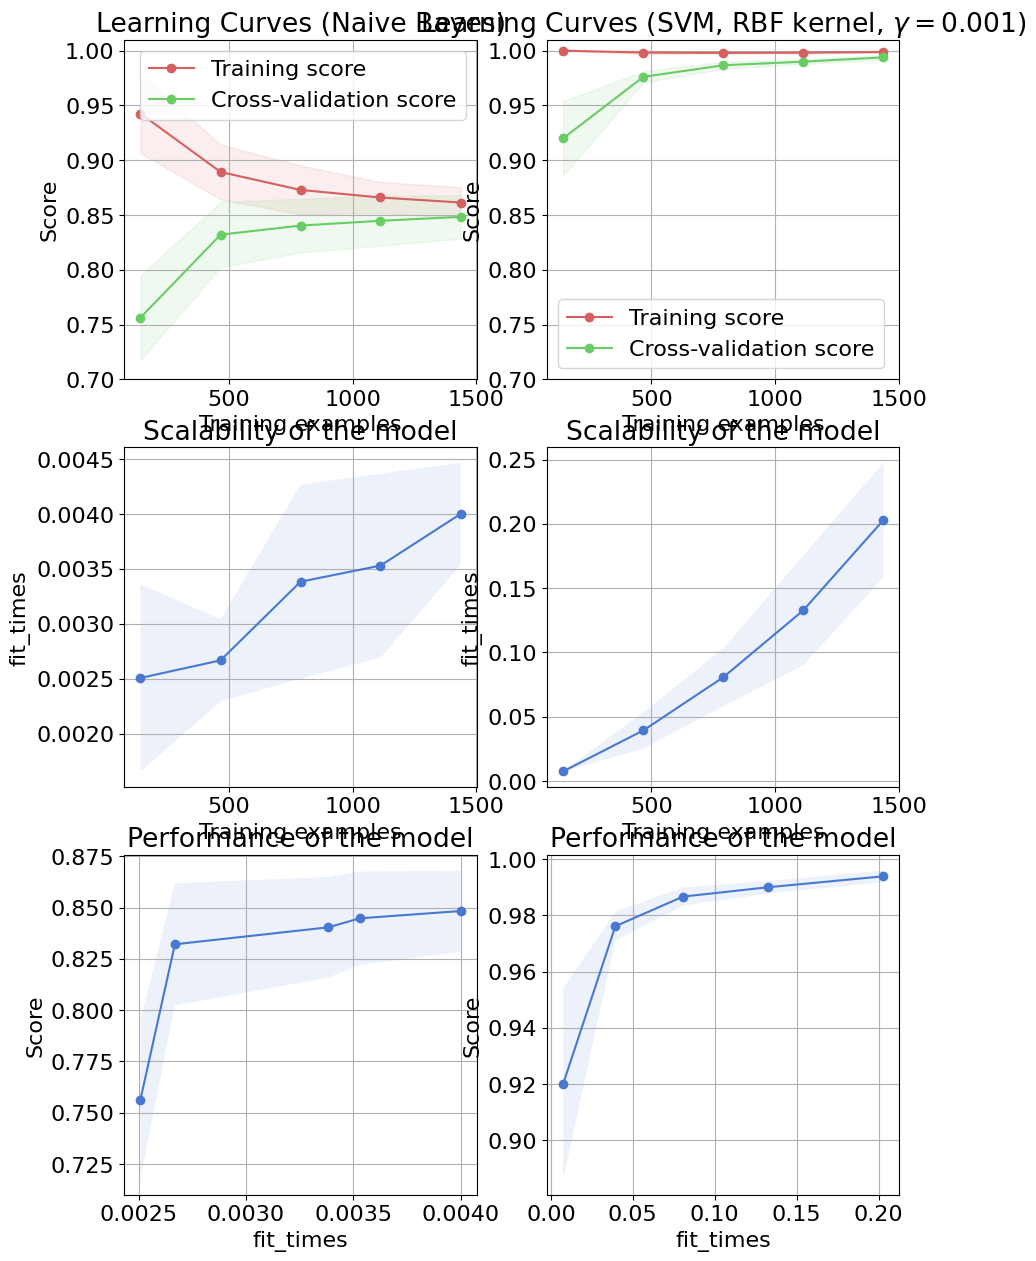

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
    title : str
        Title for the chart.
    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.
    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.
    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.
    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).
    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt




TypeError: plot_learning_curve() missing 2 required positional arguments: 'X' and 'y'

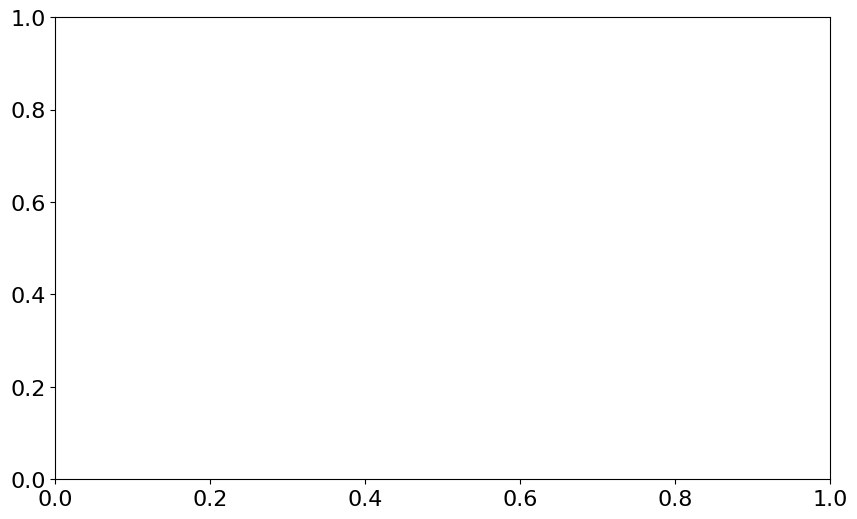

In [119]:

fig, ax = plt.subplots(figsize=(10,6))
plot_learning_curve(results_superclass2, ax)

In [120]:
with open('./train_history/superclass_highparams.png', 'wb') as file_pi:
        pickle.dump(results_superclass2.history, file_pi)

In [121]:
results_superclass2_load = pickle.load( open('./train_history/superclass_highparams.hist', "rb" ) )

In [122]:
type(results_superclass2.history)

dict

In [123]:
results_superclass2_load.keys()

dict_keys(['loss', 'class_output_loss', 'superclass_output_loss', 'class_output_accuracy', 'superclass_output_accuracy', 'val_loss', 'val_class_output_loss', 'val_superclass_output_loss', 'val_class_output_accuracy', 'val_superclass_output_accuracy', 'lr'])

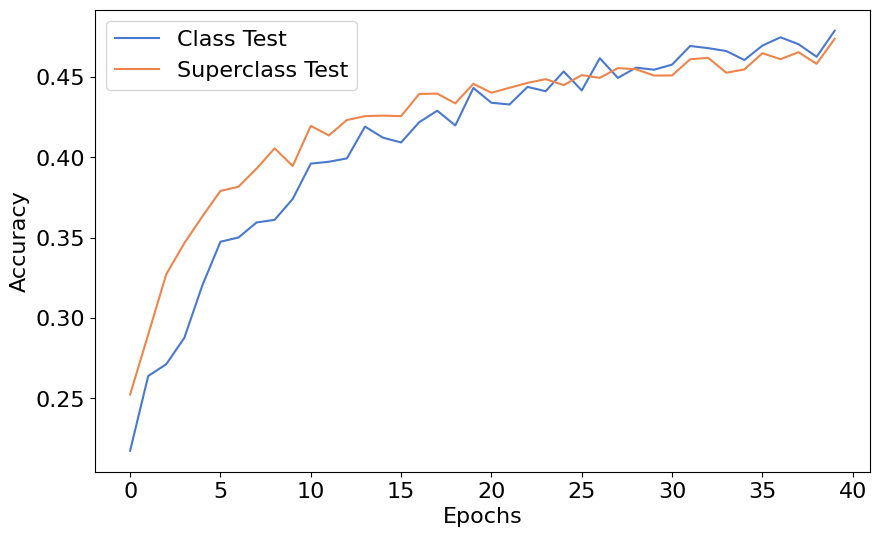

In [124]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_superclass2_load, ax, 
             categories=['val_class_output_accuracy', 'val_superclass_output_accuracy'], 
             labels=['Class Test', 'Superclass Test'])